In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
#import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def read_data(which='blood'):
    fpath = '../../resources/rat-metabolites/Rat_' + which + '_27_Oct_2022.csv'
    data = pd.read_csv(fpath, index_col='idno')
    metabolites = data.columns[4:]
    metabolites2exclude = [m for m in metabolites if data.loc[:, m].isna().sum() > len(data) * 0.2]
    data = data.drop(metabolites2exclude, axis=1)
    return(data)

blood = read_data(which='blood')
brain = read_data(which='brain')
brain

,LIScore,Group,material,species,tca,c0,c2,c3,c4,c5,...,peaec401,peaec422,pgaac320,pgaac341,pgaac362,pgaac364,pgaac385,psaac341,psaac361,psaac406
idno,,,,,,,,,,,,,,,,,,,,,
105,249,AI,brain tissue,rat,NaN,11.034,1.521,NaN,NaN,0.033825,...,1.097,1.350,0.3983,4.147,0.6962,2.943,0.6260,3.963,23.820,95.495
1158,201,AU,brain tissue,rat,0.32700,10.904,4.107,0.142000,0.158000,0.068129,...,1.234,1.143,0.3517,3.036,0.5238,2.593,0.5484,4.052,NaN,76.815
1172,155,AU,brain tissue,rat,0.37800,10.132,4.187,0.072465,0.128000,0.066152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1174,194,AU,brain tissue,rat,0.14600,10.024,4.249,0.146000,0.206000,0.132000,...,1.189,1.153,0.3748,3.530,0.5092,2.393,0.5173,3.979,34.066,65.968
127,291,AI,brain tissue,rat,NaN,11.611,3.001,NaN,0.088304,0.062654,...,1.145,1.413,0.4821,4.428,0.6463,2.665,0.5714,4.618,39.461,93.804
1368,285,AI,brain tissue,rat,0.03720,8.753,3.696,0.105000,0.145000,0.051299,...,1.234,1.368,0.3546,3.127,0.5751,2.273,0.5582,4.621,25.287,77.199
1416,274,AI,brain tissue,rat,0.62000,9.513,3.632,0.103000,0.145000,0.071780,...,1.313,1.448,0.4991,4.396,0.5918,2.794,0.6199,4.747,29.181,86.504
1424,216,AU,brain tissue,rat,0.60400,32.689,10.832,2.675000,0.447000,0.488000,...,1.184,1.161,0.3523,4.077,0.5641,2.460,0.5011,4.536,NaN,81.504
143,280,AI,brain tissue,rat,NaN,18.695,3.930,0.031219,0.105000,0.070783,...,1.547,1.343,0.4119,3.952,0.6400,2.335,0.5619,4.110,37.249,72.777


In [3]:
def extract2groups(metabolite, groupA='AU', groupB='AI', df=blood):
    l = [df.loc[df.Group == g, metabolite].dropna() for g in [groupA, groupB]]
    return(l)

def get_log_p(A, B):
    val = - np.log10(stats.ttest_ind(A, B)[1])
    return(val)

def get_effect_size(A, B):
    '''
    The effect size x is B relative to A, so if A > B => x < 0
    '''
    #val = B.mean() - A.mean()
    OR = B.mean() / A.mean()
    log2OR = np.log2(OR)
    return(log2OR)

def get_both(metabolite, groupA='AU', groupB='AI', df=blood):
    A, B = extract2groups(metabolite, groupA, groupB, df)
    log_p = get_log_p(A, B)
    fx_size = get_effect_size(A, B)
    return((fx_size, log_p))

def get_both_all(groupA='AU', groupB='AI', df=blood):
     metabolites = df.columns[4:]
     l = [get_both(m, groupA, groupB, df) for m in metabolites]
     fx_sizes = [x[0] for x in l]
     log_ps = [x[1] for x in l]
     return((fx_sizes, log_ps))

In [7]:
comparisons = {
    'AI vs. AU': ['AU', 'AI'],
    'AI vs. Y': ['Y', 'AI'],
    'AU vs. Y': ['Y', 'AU'],
              }
results_blood = {k: get_both_all(*v, df=blood) for k, v in comparisons.items()}
results_brain = {k: get_both_all(*v, df=brain) for k, v in comparisons.items()}

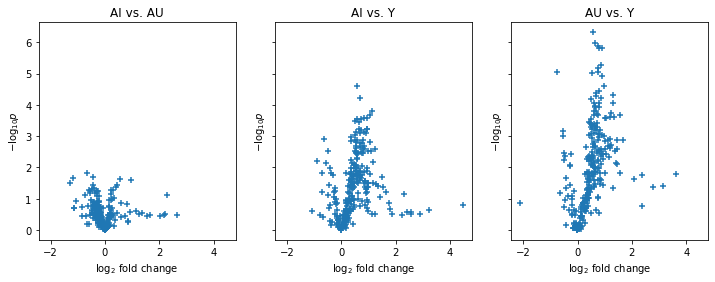

In [8]:
def my_volcano(results):
    fig, ax = plt.subplots(1, len(comparisons), figsize=(12, 4), sharey=True, sharex=True)
    for axi, comparison in zip(ax, comparisons):
        axi.scatter(x=results[comparison][0], y=results_blood[comparison][1], marker='+')
        axi.set_title(comparison)
        axi.set_xlabel(r'$\log_{2}$ fold change')
        axi.set_ylabel(r'$- \log_{10} p$')
    return((fig, ax))

fig, ax = my_volcano(results_blood)
#attila_utils.savefig(fig, 'volcano-plots')

ValueError: x and y must be the same size

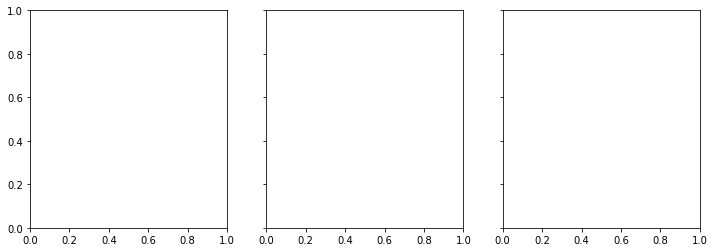

In [9]:
fig, ax = my_volcano(results_brain)

In [6]:
%connect_info

{
  "shell_port": 62220,
  "iopub_port": 62221,
  "stdin_port": 62222,
  "control_port": 62224,
  "hb_port": 62223,
  "ip": "127.0.0.1",
  "key": "373619fc-3b61f99e3195f861cb78905d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-1ce1b008-f7e8-4d63-864f-18f44bb6ae28.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
